# MA 506 Probability and Statistical Inference
# Lecture 20: Model Selection

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Model selection strategies 

Here we will discuss the strategy to select the best model, which boils down to finding the best $\lambda$ in the Regression model. This is more general than the strategies we have discussed in the last 2 classes.

## 1. Divide the dataset into 3 sets

1. Training (60% - 70%)
2. Validation (10% - 20%)
3. Testing (10% - 20%)

The idea is as follows. Suppose we want to choose between two $\lambda$ values: $\lambda_1$ and $\lambda_2$

1. For each $\lambda_i$, fit the regression model on the training data.
2. Then compute the performance (Mean Squared Error) on the validation data.
3. Whichever $\lambda_i$ produces the minimum error on the validation set should be chosen as the best $\lambda_i$.

Using the chosen $\lambda_i$, report the performance (Mean Squared Error) on the testing dataset.

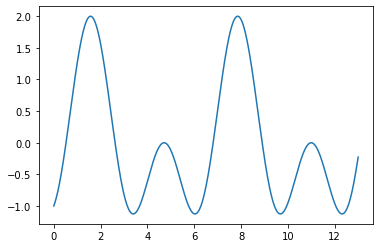

In [9]:
x = np.linspace(0.001,13,1000)
y = np.sin(x)-np.cos(2*x)
plt.plot(x,y);

In [10]:
np.random.seed(1)
err = np.random.randn(1000)*0.5
y_err = y + err

In [11]:
fig = plt.figure(figsize=(10,5))
plt.plot(x,y,color = 'r',lw = 2,label = 'True function');
plt.scatter(x,y_err, label = 'Noisy samples');
plt.legend(prop = {'size':15});

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [13]:
print(len(y_train),len(y_val),len(y_test))

680 170 150


### Choosing between $2 \lambda$ values for Lasso Regression

In [14]:
def X_mat2(x):
    X = []
    for i in x:
        X.append([1, np.sin(i), np.cos(2*i)])
    return np.array(X)

In [15]:
lambda1 = [1.0e-8, 1]
for i in lambda1:
    lsr = Lasso(alpha=i)
    lsr.fit(X_mat2(X_train), y_train)
    pred_val = lsr.predict(X_mat2(X_val))
    print(f'lambda: {i}; Validation MSE: {mean_squared_error(y_val,pred_val)}')

lambda: 1e-08; Validation MSE: 4.778768915781869e-16
lambda: 1; Validation MSE: 1.0015388164876242


Hence $10^{-8}$ is preferable

In [16]:
def plot_val_error_Lasso(X_train,y_train,X_val,y_val):
    X = X_mat2(X_train)
    lambda1 = np.arange(1.0e-16,1.0e-8,1.0e-11)
    per = []
    for i in lambda1:
        lsr = Lasso(alpha=i)
        lsr.fit(X, y_train)
        pred_val = lsr.predict(X_mat2(X_val))
        per.append(mean_squared_error(y_val,pred_val))
    
    plt.plot(lambda1,per)
    plt.show()

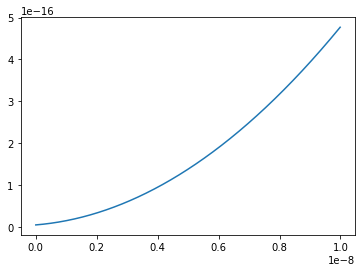

In [17]:
plot_val_error_Lasso(X_train,y_train,X_val,y_val)

Hence some very small value of $\lambda$ should do the job

## 2. K-fold Cross Validation

Problems with the previous approach:
1. Due to randomness in the approach, we might not get a good set of samples in the validation set, leading to an inefficient choice of $\lambda$
2. Since, changing the samples in the training and validation set might lead to a different chosen model each time, it's referred to as a high variance estimate, which is not preferable.

This leads us to K-fold Cross Validation where data is divided into subsets multiple times systematically, so that each data point is part of the validation set ones.

### 2.1 Idea of K-CV

The idea is as follows. Suppose we want to choose between two $\lambda$ values: $\lambda_1$ and $\lambda_2$

Divide the dataset into two part
1. Training dataset: D1
2. Testing dataset: D2

Like Before, all model training will happen on D1. Final performance of the chosen model will be reported on D2.

Now just considering D1, for every $\lambda_i$,
1. Split D1 into K equal partitions (also known as K folds). Each fold contains approximately equal number of samples.
2. Use fold 1 as the validation set and union of other folds as the training set
        For example if our data has 100 samples, then with K = 5, dataset would be divided into 5 groups(folds) of 20 samples. One of these fold will be used for validation and remaining 80 samples for training.
3. Calculate validation accuracy
4. Repeat steps 2 and 3, K times. Use different fold as the validation set each time
5. Use average validation accuracy as a measure of performance.

The $\lambda_i$ with best average validation accuracy is chosen. Report the performance of the best $\lambda_i$ on testing set.

In [18]:
## Implementing K-fold CV in sklearn for any algorithm

In [19]:
## A test
from sklearn.model_selection import KFold
X = np.array(["a", "b", "c", "d","e","f","g","h","i","j"])
kf = KFold(n_splits=5)

for train, test in kf.split(X):
    print(train, test)
    print(X[train],X[test])

[2 3 4 5 6 7 8 9] [0 1]
['c' 'd' 'e' 'f' 'g' 'h' 'i' 'j'] ['a' 'b']
[0 1 4 5 6 7 8 9] [2 3]
['a' 'b' 'e' 'f' 'g' 'h' 'i' 'j'] ['c' 'd']
[0 1 2 3 6 7 8 9] [4 5]
['a' 'b' 'c' 'd' 'g' 'h' 'i' 'j'] ['e' 'f']
[0 1 2 3 4 5 8 9] [6 7]
['a' 'b' 'c' 'd' 'e' 'f' 'i' 'j'] ['g' 'h']
[0 1 2 3 4 5 6 7] [8 9]
['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h'] ['i' 'j']


### 1. Dividing into training and testing

In [20]:
X_d1, X_d2, y_d1, y_d2 = train_test_split(x, y, test_size=0.15, random_state=42)

### 2. Evaluating performance for different $\lambda_i$

In [21]:
lambda1 = [1.0e-8, 1]
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
for i in lambda1:
    val_per = []
    for train, val in kf.split(X):
        ## Getting the training and validation set from D1
        X_train = X_d1[train]
        y_train = y_d1[train]  
        X_val = X_d1[val]
        y_val = y_d1[val]
        lsr = Lasso(alpha=i)
        lsr.fit(X_mat2(X_train), y_train)
        pred_val = lsr.predict(X_mat2(X_val))
        val_per.append(mean_squared_error(y_val,pred_val))
        
    print(f'lambda: {i}; Validation MSE: {np.mean(val_per)}')

lambda: 1e-08; Validation MSE: 3.304179918374903e-11
lambda: 1; Validation MSE: 1.3257430259636016


### 3. Report the performance of the best model on testing set: D2

In [22]:
lsr = Lasso(alpha=1.0e-8)
lsr.fit(X_mat2(X_train), y_train)
pred_test = lsr.predict(X_mat2(X_test))
mean_squared_error(y_test,pred_test)

3.4932355720298816e-12

## 3. Using LassoCV from sklearn

In [23]:
from sklearn.linear_model import LassoCV
reg = LassoCV(cv=5, random_state=0).fit(X_mat2(X_d1), y_d1)

In [24]:
reg.alphas_

array([0.50958117, 0.47523711, 0.44320772, 0.413337  , 0.38547947,
       0.35949944, 0.33527038, 0.31267428, 0.29160108, 0.27194815,
       0.25361975, 0.23652663, 0.22058552, 0.2057188 , 0.19185404,
       0.17892372, 0.16686486, 0.15561873, 0.14513055, 0.13534923,
       0.12622715, 0.11771986, 0.10978594, 0.10238673, 0.09548621,
       0.08905076, 0.08304903, 0.07745181, 0.07223181, 0.06736363,
       0.06282355, 0.05858945, 0.05464072, 0.05095812, 0.04752371,
       0.04432077, 0.0413337 , 0.03854795, 0.03594994, 0.03352704,
       0.03126743, 0.02916011, 0.02719481, 0.02536198, 0.02365266,
       0.02205855, 0.02057188, 0.0191854 , 0.01789237, 0.01668649,
       0.01556187, 0.01451305, 0.01353492, 0.01262271, 0.01177199,
       0.01097859, 0.01023867, 0.00954862, 0.00890508, 0.0083049 ,
       0.00774518, 0.00722318, 0.00673636, 0.00628235, 0.00585895,
       0.00546407, 0.00509581, 0.00475237, 0.00443208, 0.00413337,
       0.00385479, 0.00359499, 0.0033527 , 0.00312674, 0.00291

In [25]:
pred_test = reg.predict(X_mat2(X_test))
mean_squared_error(y_test,pred_test)

1.0221117796548632e-06